In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def check_model(model):
    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"num_params: {num_params}")
    is_cuda = next(model.parameters()).is_cuda
    if is_cuda:
        device_name = torch.cuda.get_device_name(0)
        memory_allocated = torch.cuda.memory_allocated(0) / 1024 ** 3  #GB
        memory_cached = torch.cuda.memory_reserved(0) / 1024 ** 3  # GB
        print(f"memory on {device_name}")
        print(f"memory_allocated: {memory_allocated:.2f} GB")
        print(f"memory_cached: {memory_cached:.2f} GB")



def generate_gaussian_images(batch_size, H, W, device='cpu'):
    """
    生成一批具有随机高斯分布参数的二维图像
    
    参数:
    batch_size (int): 批大小
    H (int): 图像高度
    W (int): 图像宽度
    device (str): 运行设备, 默认为 'cpu'
    
    返回:
    images (torch.Tensor): 形状为 (batch_size, H, W) 的图像张量
    mu_x (torch.Tensor): 形状为 (batch_size,) 的 x 方向均值
    mu_y (torch.Tensor): 形状为 (batch_size,) 的 y 方向均值
    sigma_x (torch.Tensor): 形状为 (batch_size,) 的 x 方向标准差
    sigma_y (torch.Tensor): 形状为 (batch_size,) 的 y 方向标准差
    """
    # 生成随机高斯分布参数
    mu_x = torch.rand(batch_size, device=device) * W # [0,W)
    mu_y = torch.rand(batch_size, device=device) * H # [0,H)
    sigma_x = torch.rand(batch_size, device=device) * (W / 4) + (W / 8) # [W/8,W/4]
    sigma_y = torch.rand(batch_size, device=device) * (H / 4) + (H / 8) # [H/8,H/4]
    
    # 生成二维高斯分布图像
    xx, yy = torch.meshgrid(torch.arange(W, device=device), torch.arange(H, device=device))
    images = torch.exp(-((xx[None, :, :] - mu_x[:, None, None])**2 / (2 * sigma_x[:, None, None]**2) +
                        (yy[None, :, :] - mu_y[:, None, None])**2 / (2 * sigma_y[:, None, None]**2))) / \
             (2 * np.pi * sigma_x[:, None, None] * sigma_y[:, None, None])
    
    return images.unsqueeze(1), mu_x, mu_y, sigma_x, sigma_y

In [2]:

# # 生成 10,000 组数据并保存
# num_samples = 10000
# batch_size = 100
# H, W = 28, 28

# images, x, y, mu_x, mu_y, sigma_x, sigma_y = [], [], [], [], [], [], []
# for _ in range(num_samples // batch_size):
#     batch_images, batch_x, batch_y, batch_mu_x, batch_mu_y, batch_sigma_x, batch_sigma_y = generate_gaussian_images(batch_size, H, W)
#     images.append(batch_images)
#     x.append(batch_x)
#     y.append(batch_y)
#     mu_x.append(batch_mu_x)
#     mu_y.append(batch_mu_y)
#     sigma_x.append(batch_sigma_x)
#     sigma_y.append(batch_sigma_y)

# images = torch.cat(images, dim=0)
# x = torch.cat(x, dim=0)
# y = torch.cat(y, dim=0)
# mu_x = torch.cat(mu_x, dim=0)
# mu_y = torch.cat(mu_y, dim=0)
# sigma_x = torch.cat(sigma_x, dim=0)
# sigma_y = torch.cat(sigma_y, dim=0)
# params = torch.cat([x.unsqueeze(1), y.unsqueeze(1),mu_x.unsqueeze(1), mu_y.unsqueeze(1), sigma_x.unsqueeze(1), sigma_y.unsqueeze(1)], dim=1)

# torch.save({'images': images, 'params':params}, 'gaussian_data.pt')

# 从文件中读取数据
# data = torch.load('gaussian_data.pt')
# images = data['images']
# params = data['params']


# print(images.shape, params.shape)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class GaussianImageDataset(Dataset):
    def __init__(self, file_path):
        data = torch.load(file_path)
        self.images = data['images']
        self.params = data['params']

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        return self.images[idx], self.params[idx]

# Create the DataLoader


class GaussianImageDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=False):
        collate_fn = self.get_collate_fn()
        super().__init__(
            dataset=dataset,
            batch_size=batch_size,
            collate_fn=collate_fn,
            shuffle=shuffle,
        )
    
    def get_collate_fn(self):
        def collate_fn(batch):
            # list of tuples of tensor, convert to tensor:
            images, params = zip(*batch) 
            # 2 tuples of tensor: (B, [C, H, W]), (B, [6])
            # convert to tensor: [B, C, H, W], [B, 6]
            images = torch.stack(images, dim=0)
            params = torch.stack(params, dim=0)
    
            batch  = (images, params) # 1 tuple of tensor: ([B, C, H, W], [B, 6])
            return batch
        return collate_fn
    
# dataset = GaussianImageDataset('gaussian_data.pt')
# batch_size = 16
# data_loader = GaussianImageDataLoader(
#     dataset,
#     batch_size=batch_size,
# )

# for batch in data_loader:
#     images, params = batch
#     # Do something with the batch data
#     print(f"Batch shape: images={images.shape}, params={params.shape}")
    



这段代码定义了一个 WGAN 损失函数类,包括生成器损失 `generator_loss` 和判别器损失 `discriminator_loss`。让我们来逐步解释一下:

1. 在 `__init__` 方法中,我们初始化了生成器 `G` 和判别器 `D` 对象,同时还定义了梯度惩罚的系数 `lambda_gp`。

2. `generator_loss` 方法计算生成器的损失函数。它接受生成的假图像 `fake_images` 和相关参数 `fake_params`,并将其传递给判别器 `D`。然后,它计算 `-d_fake.mean()` 作为生成器的损失函数。这是因为在 WGAN 中,生成器的目标是最大化判别器的输出。

3. `discriminator_loss` 方法计算判别器的损失函数。它接受真实图像 `real_images`、相关参数 `real_params`、生成的假图像 `fake_images` 和相关参数 `fake_params`。

   - 首先,它计算判别器对真实图像和生成图像的输出 `d_real` 和 `d_fake`。
   - 然后,它计算判别器的损失函数 `d_loss = d_fake.mean() - d_real.mean()`。这是因为在 WGAN 中,判别器的目标是最小化生成图像的得分,同时最大化真实图像的得分。
   - 接下来,它计算梯度惩罚。它通过插值真实图像和生成图像来创建中间图像 `interpolates`,并计算判别器对这些中间图像的输出 `d_interpolates`。然后,它计算这些中间图像的梯度 `gradients`,并根据 `lambda_gp` 来计算梯度惩罚 `gradient_penalty`。最后,将梯度惩罚项添加到 `d_loss` 中。

总之,这个 WGAN_Loss 类提供了 WGAN 损失函数的实现,包括生成器损失和判别器损失,并附加了梯度惩罚项以提高训练的稳定性。

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim:int, img_size: int):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.gauss_emb = nn.Linear(4, 4)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + 4, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, int(self.img_size**2)),
            nn.Tanh()
        )

    def forward(self, z, params):
        # z: latent vector [z,1]
        # params: concatenated center, mean and std dev, [B,6]
        input = torch.cat([z, self.gauss_emb(params)], dim=1)
        img = self.model(input)
        img = img.view(img.size(0), 1, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size: int):
        super(Discriminator, self).__init__()
        self.gauss_emb = nn.Linear(4, 4)
        self.model = nn.Sequential(
            nn.Linear(img_size**2 + 4, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, params):
        # img:  [B,H,W]
        # params: concatenated mean and std dev, [B,6]
        d_in = torch.cat([img.view(img.size(0), -1), self.gauss_emb(params)], dim=1)
        return self.model(d_in) #[B,H*W+6]

# WGAN-GP loss
class WGAN_Loss:
    def __init__(self, generator, discriminator, lambda_gp=10):
        self.G = generator
        self.D = discriminator
        self.lambda_gp = lambda_gp

    def generator_loss(self, fake_images, fake_params):
        # Generator loss
        d_fake = self.D(fake_images, fake_params)
        g_loss = -d_fake.mean()
        return g_loss

    def discriminator_loss(self, real_images, real_params, fake_images, fake_params):
        # Discriminator loss
        d_real = self.D(real_images, real_params)
        d_fake = self.D(fake_images, fake_params)
        d_loss = d_fake.mean() - d_real.mean()

        # Gradient penalty
        alpha = torch.rand(real_images.size(0), 1, 1, 1).to(real_images.device)
        interpolates = alpha * real_images + (1 - alpha) * fake_images
        interpolates.requires_grad_(True)
        d_interpolates = self.D(interpolates, real_params)
        gradients = torch.autograd.grad(d_interpolates, interpolates, grad_outputs=torch.ones_like(d_interpolates), create_graph=True, retain_graph=True)[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_gp
        d_loss += gradient_penalty

        return d_loss
    
class WGAN_GP:
    def __init__(self, generator, discriminator, optimizer_G, optimizer_D, lambda_gp=10):
        self.G = generator
        self.D = discriminator
        self.optimizer_G = optimizer_G
        self.optimizer_D = optimizer_D
        self.criterion = WGAN_Loss(generator, discriminator, lambda_gp)

    def train_step(self, real_images, real_params):
        # Generate fake images and params
        z = torch.randn(real_images.size(0), self.G.latent_dim, device=real_images.device)
        fake_images = self.G(z, real_params)
        # print(fake_images.size())
        # print(real_images.size())
        fake_params = real_params

        # Update discriminator
        self.optimizer_D.zero_grad()
        d_loss = self.criterion.discriminator_loss(real_images, real_params, fake_images.detach(), fake_params.detach())
        d_loss.backward()
        self.optimizer_D.step()

        # Update generator
        self.optimizer_G.zero_grad()
        g_loss = self.criterion.generator_loss(fake_images, fake_params)
        g_loss.backward()
        self.optimizer_G.step()

        return d_loss.item(), g_loss.item()

In [5]:

# 定义训练函数
def train(opt, device="cpu"):
    # 训练模型
    num_epochs=opt.num_epochs #100000
    batch_size=opt.batch_size  # 256, 
    latent_dim = opt.latent_dim  # 100
    img_size = opt.img_size  # 28
        
    generator = Generator(latent_dim, img_size).to(device)
    discriminator = Discriminator(img_size).to(device)
    check_model(generator)
    check_model(discriminator)

    # 0-1000
    if opt.load_g:
        generator.load_state_dict(torch.load('gauss_g.pth',map_location=torch.device(device)))
    if opt.load_d:
        discriminator.load_state_dict(torch.load('gauss_d.pth',map_location=torch.device(device)))

    g_optimizer = optim.RMSprop(generator.parameters(), lr=opt.lr)
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=opt.lr)

    # Create the dataset and dataloader
    dataset = GaussianImageDataset(opt.train_path)
    dataloader = GaussianImageDataLoader(
        dataset,
        batch_size=batch_size,
    )
    model = WGAN_GP(generator, discriminator, g_optimizer, d_optimizer, lambda_gp=10)
    
    g_losses = []
    d_losses = []
    losses_G_epoch=[]
    losses_D_epoch=[]
    check_loss = opt.num_epochs/100
    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_images, params = batch
            # for real_images, params in dataloader:
            # params: [B,6]
            d_loss,g_loss=model.train_step(real_images, params)
            g_losses.append(g_loss) 
            d_losses.append(d_loss) 
        # print(i)
        loss_G_epoch = sum(g_losses)/len(g_losses)
        losses_G_epoch.append(loss_G_epoch)
        loss_D_epoch = sum(d_losses)/len(d_losses)
        losses_D_epoch.append(loss_D_epoch)
        if (epoch+1) % check_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Disc Loss: {loss_D_epoch:.4f}, Gen Loss: {loss_G_epoch:.4f}")
    
    torch.save(generator.state_dict(), 'gauss_generator.pth')
    torch.save(discriminator.state_dict(), 'gauss_discriminator.pth')
    return g_losses, d_losses, losses_G_epoch, losses_D_epoch


In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class opt:
    num_epochs= 10 # 1000
    batch_size= 256
    latent_dim = 100
    img_size = 28
    lr = 5e-5
    load_g = True # False
    load_d = True #False
    datafolder = '../../data/gauss/'
    train_path = datafolder + 'train_data.pt'

Generator(
  (gauss_emb): Linear(in_features=4, out_features=4, bias=True)
  (model): Sequential(
    (0): Linear(in_features=104, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
num_params: 1487396
Discriminator(
  (gauss_emb): Linear(in_features=4, out_features=4, bias=True)
  (model): Sequential(
    (0): Linear(in_features=788, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
num_params: 535573


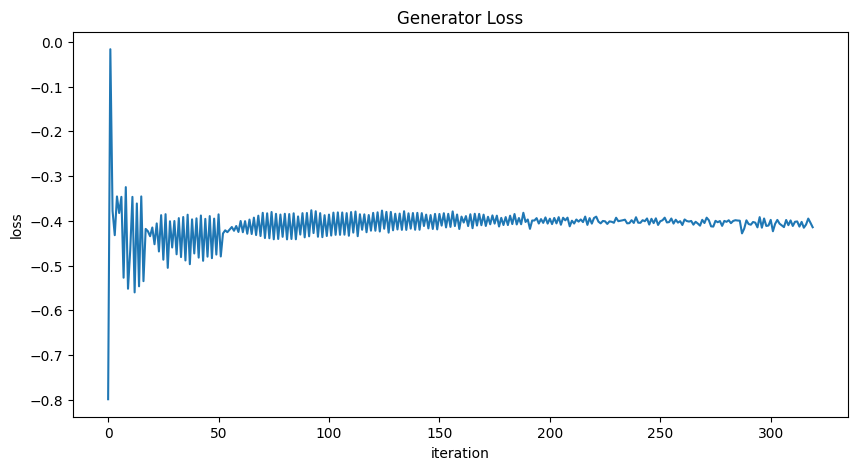

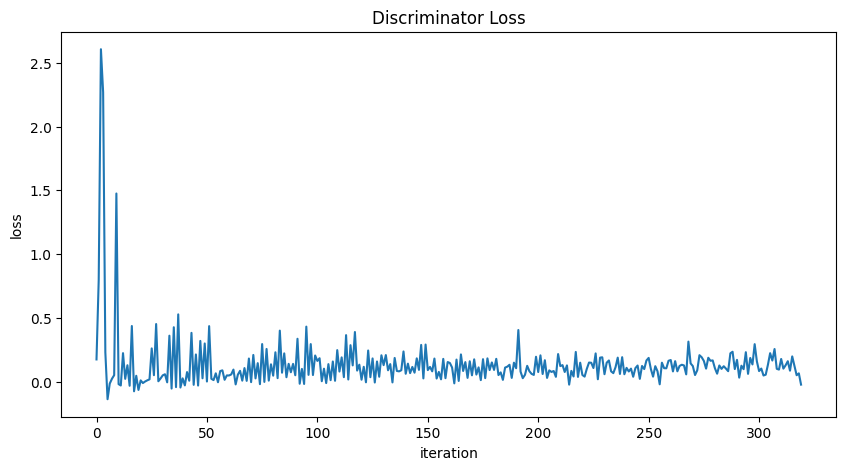

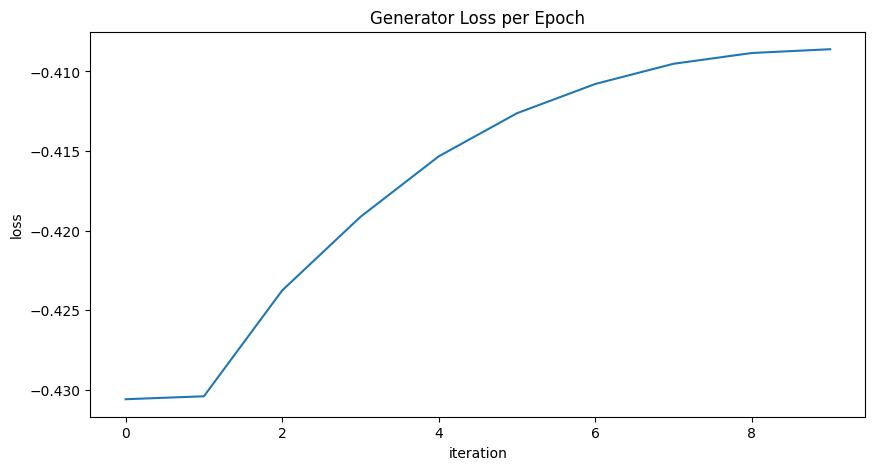

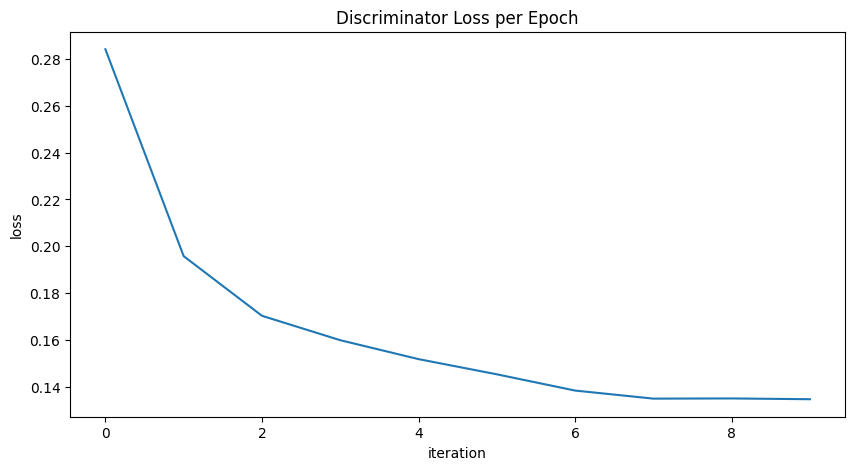

In [7]:

g_losses, d_losses, losses_G_epoch, losses_D_epoch = train(opt)

def plot_loss(loss_list, title):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_list)
    plt.title(title)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

plot_loss(g_losses, 'Generator Loss')
plot_loss(d_losses, 'Discriminator Loss')
plot_loss(losses_G_epoch, 'Generator Loss per Epoch')
plot_loss(losses_D_epoch, 'Discriminator Loss per Epoch')

e:\_software\anaconda\envs\capstone\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


L1 distance: 0.2872, L2 distance: 0.1267
L1 distance: 0.2397, L2 distance: 0.0903
L1 distance: 0.2867, L2 distance: 0.1265
L1 distance: 0.1523, L2 distance: 0.0478


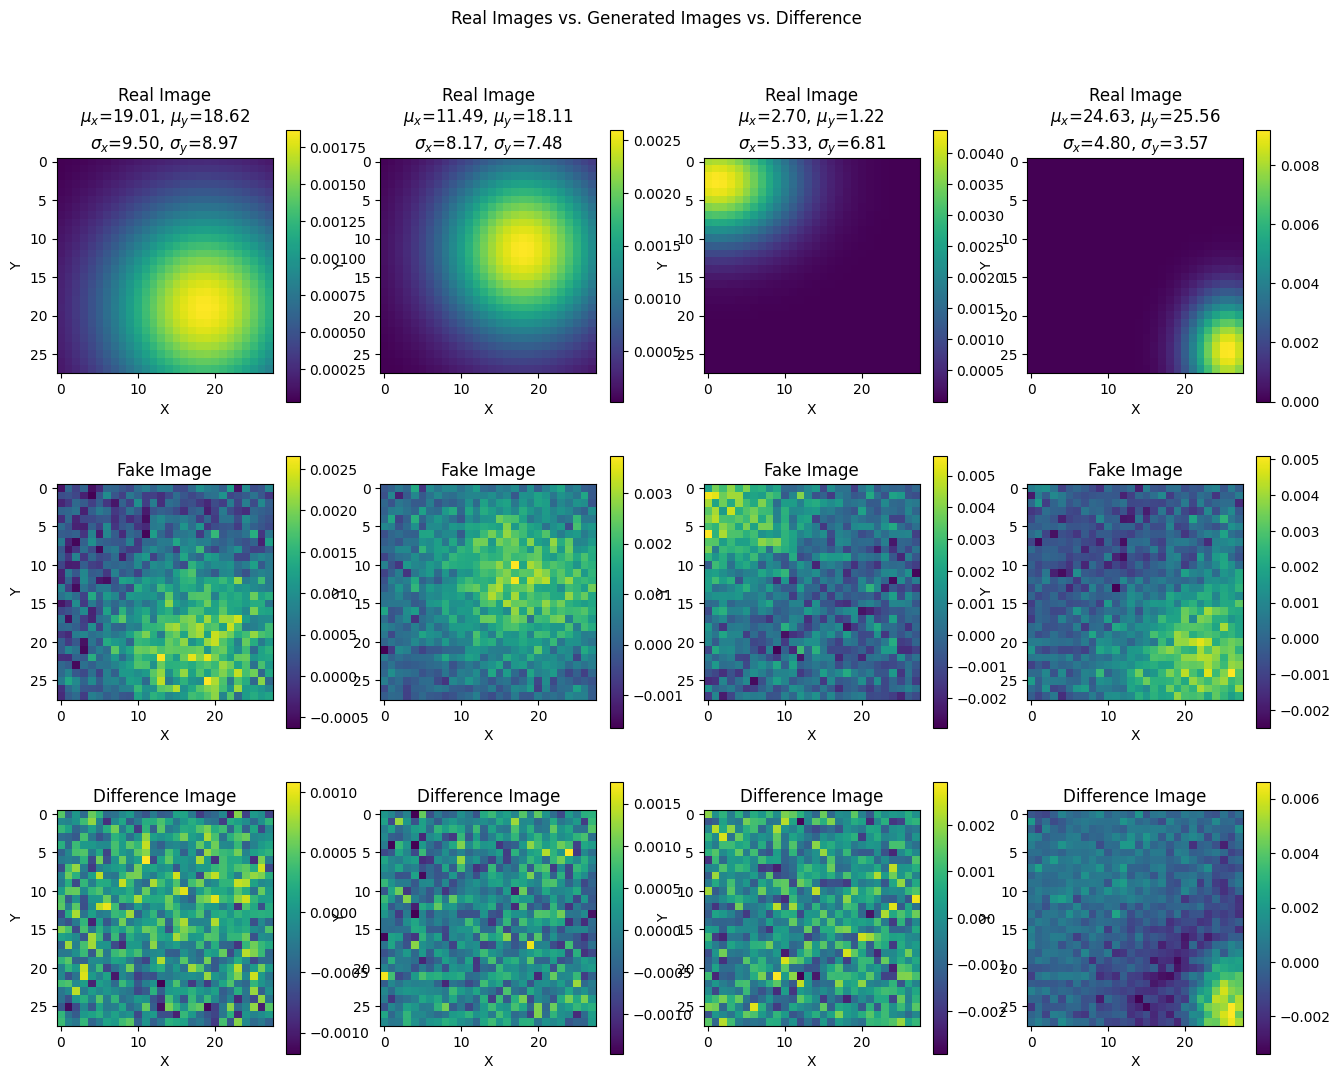

In [8]:
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# 加载训练好的生成器模型
generator = Generator(latent_dim=100, img_size=28).to(device)
generator.load_state_dict(torch.load('gauss_generator.pth'))
generator.eval()

def test(generator, num_samples=4, device="cpu"):
    """
    使用训练好的生成器和判别器进行测试。
    生成一些样本图像并保存到磁盘。
    """
    # 生成噪声输入
    noise = torch.randn(num_samples, 100, device=device)
    # torch.randn 默认范围：[0, 1)

    # 生成图像
    with torch.no_grad():
        # 生成高斯分布样本的参数
        real_images, mu_x, mu_y, sigma_x, sigma_y = generate_gaussian_images(num_samples, 28, 28, device)
        params = torch.cat([mu_x.unsqueeze(1), mu_y.unsqueeze(1), sigma_x.unsqueeze(1), sigma_y.unsqueeze(1)], dim=1)
        
        # 使用生成器生成图像
        fake_images = generator(noise, params)

    # 保存生成的图像
    # save_image(fake_images, 'generated_images.png', nrow=4, normalize=True)
    # print(f"生成的图像已保存到 'generated_images.png'.")

    # 绘制 real images 和 fake images 的对比图 [4, 1, 28, 28]
    
    fig, ax = plt.subplots(3, 4, figsize=(16, 12))
    for i in range(num_samples):
        # 绘制 real images
        real_img = ax[0, i].imshow(real_images[i].permute(1, 2, 0).cpu(), cmap='viridis')
        ax[0, i].set_title(f"Real Image\n$\mu_x$={mu_x[i].item():.2f}, $\mu_y$={mu_y[i].item():.2f}\n$\sigma_x$={sigma_x[i].item():.2f}, $\sigma_y$={sigma_y[i].item():.2f}")
        ax[0, i].set_xlabel('X')
        ax[0, i].set_ylabel('Y')
        ax[0, i].axis('on')
        fig.colorbar(real_img, ax=ax[0, i])

        # 绘制 fake images
        fake_img = ax[1, i].imshow(fake_images[i].permute(1, 2, 0).cpu(), cmap='viridis')
        ax[1, i].set_title("Fake Image")
        ax[1, i].set_xlabel('X')
        ax[1, i].set_ylabel('Y')
        ax[1, i].axis('on')
        fig.colorbar(fake_img, ax=ax[1, i])

        # 绘制 real images 和 fake images 的差图
        diff_img = ax[2, i].imshow((real_images[i] - fake_images[i]).permute(1, 2, 0).cpu(), cmap='viridis')
        ax[2, i].set_title("Difference Image")
        ax[2, i].set_xlabel('X')
        ax[2, i].set_ylabel('Y')
        ax[2, i].axis('on')
        fig.colorbar(diff_img, ax=ax[2, i])

        # L1 , L2 距离, 对最大值的百分比
        l1_dist = torch.mean(torch.abs(real_images[i] - fake_images[i]))/\
                torch.max(torch.abs(real_images[i] - fake_images[i]))
        l2_dist = torch.mean((real_images[i] - fake_images[i])**2)/\
                torch.max((real_images[i] - fake_images[i])**2)
        print(f"L1 distance: {l1_dist.item():.4f}, L2 distance: {l2_dist.item():.4f}")
        
    plt.suptitle('Real Images vs. Generated Images vs. Difference')
    plt.savefig('real_vs_fake_vs_diff.png')
    plt.show()
    
# 使用方式
test(generator,device=device)
